In [28]:
import numpy as np
import re
from collections import Counter

In [29]:
class word2vec():
    def __init__ (self):
        self.n = settings['n']
        self.eta = settings['learning_rate']
        self.epochs = settings['epochs']
        self.window = settings['window_size']
        self.num_word = settings['num_word']
        pass


    # GENERATE TRAINING DATA
    def generate_training_data(self, settings, corpus):

        # GENERATE WORD COUNTS
        word_counts =dict(sorted(Counter(sum(sentences,[])).items(), key=lambda item: item[1],reverse=True))

        self.v_count = min(len(word_counts.keys()), self.num_word)

        # GENERATE LOOKUP DICTIONARIES
        self.words_list = list(word_counts.keys())
        self.word_index = dict((word, i) for i, word in enumerate(self.words_list[:self.v_count]))
        self.index_word = dict((i, word) for i, word in enumerate(self.words_list[:self.v_count]))

        training_data = []
        # CYCLE THROUGH EACH SENTENCE IN CORPUS
        for sentence in corpus:
            sent_len = len(sentence)

            # CYCLE THROUGH EACH WORD IN SENTENCE
            for i, word in enumerate(sentence):
                #w_target  = sentence[i]
                if sentence[i] in self.word_index :
                  w_target =   self.word_index[sentence[i]]

                  # CYCLE THROUGH CONTEXT WINDOW
                  w_context = []
                  for j in range(i-self.window, i+self.window+1):
                      if j!=i and j<=sent_len-1 and j>=0 and (sentence[j] in self.word_index):
                          w_context.append(self.word_index[sentence[j]])
                  if w_context != [] :
                    training_data.append([w_target, w_context])
        return np.array(training_data, dtype=object)


    # SOFTMAX ACTIVATION FUNCTION
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)


    # CONVERT WORD TO ONE HOT ENCODING
    def word2onehot(self, word):
        word_vec = [0 for i in range(0, self.v_count)]
        word_vec[word] = 1
        return word_vec


    # FORWARD PASS
    def forward_pass(self, x):
        #h = np.dot(self.w1.T, x)
        h=np.sum(self.w1[x],axis=0)
        u = np.dot(self.w2.T, h)
        y_c = self.softmax(u)
        return y_c, h, u


    # BACKPROPAGATION
    def backprop(self, e, h, x):
        dl_dw1 = np.dot(self.w2, e)
        dl_dw2 = np.outer(h, e)


        # UPDATE WEIGHTS
        for i in x :
          self.w1[i] = self.w1[i] - (self.eta * dl_dw1)
        self.w2 = self.w2 - (self.eta * dl_dw2)
        # print(self.w1.shape, dl_dw1.shape, self.w2.shape, dl_dw2.shape)
        pass


    # TRAIN W2V model
    def train(self,training_data):
        # INITIALIZE WEIGHT MATRICES
        self.w1 = np.random.uniform(-0.8, 0.8, (self.v_count, self.n))     # embedding matrix
        self.w2 = np.random.uniform(-0.8, 0.8, (self.n, self.v_count))     # context matrix
        #train_leng= len(training_data)
        # CYCLE THROUGH EACH EPOCH
        self.losses = []
        for i in range(0, self.epochs):
            #counter =0
            self.loss = 0
            # CYCLE THROUGH EACH TRAINING SAMPLE
            for t, c in training_data:

                w_t = self.word2onehot(t)
                #counter+=1
                #print(counter/train_leng)
                # FORWARD PASS
                y_pred, h, u = self.forward_pass(c)

                # CALCULATE ERROR
                EI = np.subtract( y_pred,w_t)

                # BACKPROPAGATION
                self.backprop(EI, h, c)

                # CALCULATE LOSS
                self.loss += -u[t] + np.log(np.sum(np.exp(u)))
                #self.loss += -np.sum([u[j] for j in c]) + len(w_c) * np.log(np.sum(np.exp(u)))

            #self.loss += -2*np.log(len(w_c)) -np.sum([u[word.index(1)] for word in w_c]) + (len(w_c) * np.log(np.sum(np.exp(u))))
            self.losses.append(self.loss)
            print ('EPOCH:',i, 'LOSS:', self.loss)
        pass


    # input a word, returns a vector (if available)
    def word_vec(self, word):
        w_index = self.word_index[word]
        v_w = self.w1[w_index]
        return v_w


    # input a vector, returns nearest word(s)
    def vec_sim(self, vec, top_n):

        # CYCLE THROUGH VOCAB
        word_sim = {}
        for i in range(self.v_count):
            v_w2 = self.w1[i]
            theta_num = np.dot(vec, v_w2)
            theta_den = np.linalg.norm(vec) * np.linalg.norm(v_w2)
            theta = theta_num / theta_den

            word = self.index_word[i]
            word_sim[word] = theta

        words_sorted = sorted(word_sim.items(), key=lambda item: item[1], reverse=True)

        for word, sim in words_sorted[:top_n]:
            print (word, sim)

        pass

    # input word, returns top [n] most similar words
    def word_sim(self, word, top_n):

        w1_index = self.word_index[word]
        v_w1 = self.w1[w1_index]

        # CYCLE THROUGH VOCAB
        word_sim = {}
        for i in range(self.v_count):
            v_w2 = self.w1[i]
            theta_num = np.dot(v_w1, v_w2)
            theta_den = np.linalg.norm(v_w1) * np.linalg.norm(v_w2)
            theta = theta_num / theta_den

            word = self.index_word[i]
            word_sim[word] = theta

        words_sorted = sorted(word_sim.items(), key=lambda item: item[1], reverse=True)

        for word, sim in words_sorted[:top_n]:
            print (word, sim)

        pass

In [30]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
settings = {}
settings['n'] = 50                  # dimension of word embeddings
settings['window_size'] = 2         # context window +/- center word
# settings['min_count'] = 2         # minimum word count
settings['epochs'] = 25             # number of training epochs
# settings['neg_samp'] = 10         # number of negative words to use during training
settings['learning_rate'] = 0.05    # learning rate
settings['num_word'] = 1000         # Number of the most frequent unique words
np.random.seed(0)                   # set the seed for reproducibility

# Import file
corpus_raw = ''
text_data = open("./data.txt", "r",encoding='unicode_escape')
for line in text_data.readlines():
  corpus_raw += line
text_data.close()
corpus_raw = corpus_raw.lower()

stop_words = set(stopwords.words('english'))
sentences = []
raw_sentences = re.split(r"[.,]", corpus_raw)
for sentence in raw_sentences:
  if sentence != '':
    tem = re.sub(r'[^\w\s]', '', sentence)
    temp = re.sub("[^a-zA-Z]"," ", tem).split()
    sent = []
    for word in temp:
      if word in stop_words:
        continue
      else:
        sent.append(word)
    if len(sent) > 1:
      sentences.append(sent)


In [35]:
# INITIALIZE W2V MODEL
w2v = word2vec()

# generate training data
training_data = w2v.generate_training_data(settings, sentences)

# train word2vec model
w2v.train(training_data)

EPOCH: 0 LOSS: 418792.2006675749
EPOCH: 1 LOSS: 344997.62398655043
EPOCH: 2 LOSS: 324960.2463139473
EPOCH: 3 LOSS: 314298.1832396988
EPOCH: 4 LOSS: 307854.7741422891
EPOCH: 5 LOSS: 303660.36458079104
EPOCH: 6 LOSS: 300773.11957272026
EPOCH: 7 LOSS: 298683.6871652271
EPOCH: 8 LOSS: 297108.0315593334
EPOCH: 9 LOSS: 295884.3504680997
EPOCH: 10 LOSS: 294914.09681428026
EPOCH: 11 LOSS: 294132.12263587984
EPOCH: 12 LOSS: 293493.0435824752
EPOCH: 13 LOSS: 292964.32857977354
EPOCH: 14 LOSS: 292522.13939479983
EPOCH: 15 LOSS: 292148.6269995554
EPOCH: 16 LOSS: 291830.17171167134
EPOCH: 17 LOSS: 291556.2424836856
EPOCH: 18 LOSS: 291318.6461454263
EPOCH: 19 LOSS: 291110.9869682375
EPOCH: 20 LOSS: 290928.2425774311
EPOCH: 21 LOSS: 290766.4327108488
EPOCH: 22 LOSS: 290622.3686513609
EPOCH: 23 LOSS: 290493.4661813962
EPOCH: 24 LOSS: 290377.6068751948


In [36]:
import pandas as pd
import seaborn as sns
losses= w2v.losses

In [37]:
print(losses)

[418792.2006675749, 344997.62398655043, 324960.2463139473, 314298.1832396988, 307854.7741422891, 303660.36458079104, 300773.11957272026, 298683.6871652271, 297108.0315593334, 295884.3504680997, 294914.09681428026, 294132.12263587984, 293493.0435824752, 292964.32857977354, 292522.13939479983, 292148.6269995554, 291830.17171167134, 291556.2424836856, 291318.6461454263, 291110.9869682375, 290928.2425774311, 290766.4327108488, 290622.3686513609, 290493.4661813962, 290377.6068751948]


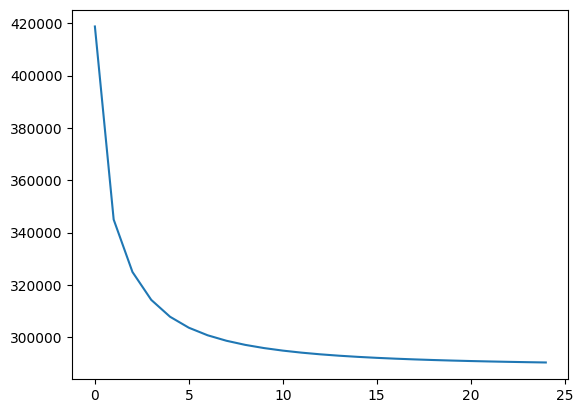

In [38]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [39]:
w2v.word_sim("machine", 10)

machine 1.0
sound 0.4305117039222027
way 0.4136653665272566
main 0.39317381149998926
life 0.3890028284734442
researchers 0.37535925071277404
developers 0.3711661479560831
code 0.36342679183031446
networks 0.36259860934392424
spending 0.3615726550630916


In [40]:
w2v.word_sim("electronic", 10)

electronic 0.9999999999999999
film 0.4735984361290346
play 0.45575438227104803
playing 0.4512876191125915
providers 0.4302934567397623
students 0.4120180745754165
electronics 0.4048204458319531
ds 0.3920443095152587
commercial 0.37083019852190086
mobile 0.3694989863586402


In [41]:
w2v.word_sim("pc", 10)

pc 0.9999999999999998
connected 0.4423840802494852
pcs 0.4011017730817533
eight 0.3805753663510596
systems 0.3780905824052768
accounts 0.3737212994957544
worth 0.36388779440265634
since 0.35268397102408405
given 0.3507709220995493
conference 0.3438672792856956


In [42]:
w2v.word_sim("mobile", 10)

mobile 1.0000000000000002
sports 0.43932848530433527
record 0.4344518005922611
add 0.40686589765555903
electronic 0.3694989863586402
also 0.3677132625364399
electronics 0.352012238819766
british 0.3356343413700376
store 0.3326327005893246
carry 0.3268066776333928


In [43]:
w2v.word_sim("new", 10)

new 1.0000000000000002
next 0.384670948185201
groups 0.38376294726410676
european 0.37023507046314286
xp 0.3625786564093264
current 0.35338020913909896
similar 0.34736787387306034
learning 0.3315814608438181
bill 0.330625178053006
bloggers 0.3288304654704399


In [44]:
w2v.word_sim("digital", 10)

digital 1.0
ea 0.4795866372153798
finding 0.4600691495699978
fans 0.4245989305813185
today 0.33388892633897105
focus 0.32971827335792464
reason 0.32948672001573365
keyboard 0.3272027872992932
capacity 0.3221010284489561
sold 0.31975325390228854


In [45]:
w2v.word_sim("software", 10)

software 1.0000000000000002
brand 0.5685622077780333
programs 0.43580559512646744
decision 0.42205351693578874
team 0.40823585343287216
considered 0.40323158681756943
program 0.3955301952693829
thousands 0.37749531033680145
image 0.35648934926823755
keen 0.3420530093017575


In [46]:
w2v.word_sim("phone", 10)

phone 1.0
phones 0.6983888772229204
telephone 0.400386903377863
owners 0.3615482297380421
energy 0.3402141047527775
senior 0.3364001398502664
work 0.33600070302292
four 0.33215326678500745
peertopeer 0.32978998822145356
association 0.3295384066727901


In [47]:
w2v.word_sim("computer", 10)

computer 1.0
computers 0.5003990712247613
played 0.43449449846748084
better 0.426656195536138
speed 0.41446869973785533
produce 0.38585051443781604
things 0.3847106546376683
usually 0.3815319688930045
operating 0.3466949679408942
someone 0.34362267043394706


In [48]:
w2v.word_sim("data", 10)

data 1.0
especially 0.4891146048731493
xp 0.41612270875327695
price 0.4118902423842395
power 0.4020355497968059
demand 0.3883442561775899
files 0.37405379695603874
problems 0.3716795262149897
businesses 0.36138114270202165
built 0.35716016579752363
